In [34]:
import pandas as pd
import numpy as np
import torch
from torch_geometric_temporal import DynamicGraphTemporalSignal
from torch_geometric_temporal.signal import temporal_signal_split
import torch.nn.functional as F
from torch_geometric_temporal.nn import A3TGCN
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the data from CSV
df = pd.read_csv('data/CollegeMsgClustered.csv')
max_nodes = 0
max_edges = 0

In [3]:
node_cluster_labels = []

for bucket_id in df["bucket_id"].unique():
    bucket_data = df[df["bucket_id"] == bucket_id]

    # Creating a mapping of node_id to its cluster label for this bucket
    src_cluster_map = dict(zip(bucket_data["src_id"], bucket_data["src_cluster"]))
    dst_cluster_map = dict(zip(bucket_data["dst_id"], bucket_data["dst_cluster"]))

    # Combining both maps. If a node appears as both src and dst, one of the labels will overwrite the other.
    # This assumes that a node can't be both src and dst with different clusters in the same bucket.
    combined_map = {**src_cluster_map, **dst_cluster_map}

    # Extracting nodes and their corresponding cluster labels
    nodes = list(combined_map.keys())
    clusters = [combined_map[node] for node in nodes]

    max_nodes = max(max_nodes, len(nodes))
    max_edges = max(max_edges, len(bucket_data))

    node_cluster_labels.append(np.array(clusters))

max_clusters = max([len(labels) for labels in node_cluster_labels])  # maximum nodes having cluster labels

In [4]:
def bucket_to_snapshot(bucket_df):
    # Combining src and dst to generate unique node set
    nodes_df = bucket_df[['src_id', 'src_cluster']].rename(columns={'src_id': 'id', 'src_cluster': 'cluster'})
    nodes_df = nodes_df.append(
        bucket_df[['dst_id', 'dst_cluster']].rename(columns={'dst_id': 'id', 'dst_cluster': 'cluster'}))
    nodes_df = nodes_df.drop_duplicates()

    # Mapping each unique node to a unique index
    node_indices = {node_id: idx for idx, node_id in enumerate(nodes_df['id'].unique())}

    # Edge indices based on the newly mapped indices
    edge_index = np.array(list(zip(bucket_df["src_id"].map(node_indices), bucket_df["dst_id"].map(node_indices)))).T

    # Generate node features based on clusters
    node_features = nodes_df[['cluster']].to_numpy(dtype=np.float32)

    targets = nodes_df['cluster'].to_numpy(dtype=np.float32)

    edge_weight = np.ones(edge_index.shape[1], dtype=np.float32)

    return edge_index, node_features, edge_weight, targets

In [5]:
snapshots = []
for bucket_id in df["bucket_id"].unique():
    edge_index, node_features, edge_weight, targets = bucket_to_snapshot(df[df["bucket_id"] == bucket_id])
    snapshots.append((edge_index, node_features, edge_weight, targets))

In [6]:
# Convert snapshots to StaticGraphTemporalSignal
edge_indices = [np.array(s[0]) for s in snapshots]
node_features = [np.array(s[1]) for s in snapshots]
edge_weights = [np.array(s[2]) for s in snapshots]
targets = [np.array(s[3]) for s in snapshots]

In [7]:
for i, idx in enumerate(node_features):
    print(f"x={node_features[i].shape},edge_index={edge_indices[i].shape}, edge_weight="
          f"{edge_weights[i].shape}, targets={targets[i].shape}")

x=(5, 1),edge_index=(2, 3), edge_weight=(3,), targets=(5,)
x=(29, 1),edge_index=(2, 23), edge_weight=(23,), targets=(29,)
x=(37, 1),edge_index=(2, 28), edge_weight=(28,), targets=(37,)
x=(43, 1),edge_index=(2, 37), edge_weight=(37,), targets=(43,)
x=(62, 1),edge_index=(2, 60), edge_weight=(60,), targets=(62,)
x=(91, 1),edge_index=(2, 125), edge_weight=(125,), targets=(91,)
x=(85, 1),edge_index=(2, 124), edge_weight=(124,), targets=(85,)
x=(95, 1),edge_index=(2, 145), edge_weight=(145,), targets=(95,)
x=(107, 1),edge_index=(2, 169), edge_weight=(169,), targets=(107,)
x=(107, 1),edge_index=(2, 183), edge_weight=(183,), targets=(107,)


In [8]:
def pad_data(data, max_size, pad_value=0):
    """A generic function to pad 1D or 2D data"""
    if len(data.shape) == 1:  # If data is 1D
        pad_length = max_size - data.shape[0]
        return np.pad(data, (0, pad_length), constant_values=pad_value)
    else:  # If data is 2D
        pad_length = max_size - data.shape[1]
        return np.pad(data, ((0,0),(0,pad_length)), constant_values=pad_value)

In [9]:
T = 2  # Adjust this based on how many periods you want to consider.

# Step 1: Identify Maximum Node Features
max_nodes = max([f.shape[0] for f in node_features])
max_features = max([f.shape[1] for f in node_features])

# Step 2: Pad all node feature matrices
padded_features = [np.pad(f, ((0, max_nodes - f.shape[0]), (0, max_features - f.shape[1]))) for f in node_features]

# Step 3: Pad all node cluster arrays
padded_features = [np.pad(f, ((0, max_nodes - f.shape[0]), (0, 0))) for f in node_features]
padded_targets = [np.pad(t.reshape(-1, 1), ((0, max_nodes - t.shape[0]), (0, 0))) for t in targets]

# Padding the list to ensure we can always get T snapshots.
node_features_padded = [np.zeros((max_nodes, 1))] * T + padded_features
node_targets_padded = [np.zeros((max_nodes, 1))] * T + padded_targets

# Now, adjust the shape to [num_nodes, periods]
temporal_features = [np.stack(node_features_padded[i-T:i], axis=-1) for i in range(T, len(node_features_padded))]
temporal_targets = [np.concatenate(node_targets_padded[i-T:i], axis=-1) for i in range(T, len(node_targets_padded))]

# Ensure all lists have the same temporal dimension
L = len(temporal_features)
edge_indices_padded = [pad_data(ei, max_edges) for ei in edge_indices][:L]
edge_weights_padded = [pad_data(ew, max_edges, pad_value=1) for ew in edge_weights][:L]

In [10]:
dataset = DynamicGraphTemporalSignal(edge_indices=edge_indices_padded, edge_weights=edge_weights_padded, features=temporal_features, targets=temporal_targets)

In [11]:
# Split the StaticGraphTemporalSignal
train_dataset, test_dataset = temporal_signal_split(dataset, 0.8)

print("Number of train buckets: ", len(train_dataset.features))
print("Number of test buckets: ", len(test_dataset.features))   

Number of train buckets:  8
Number of test buckets:  2


In [12]:
for snapshot in train_dataset:
    print(snapshot)

Data(x=[107, 1, 2], edge_index=[2, 183], edge_attr=[183], y=[107, 2])
Data(x=[107, 1, 2], edge_index=[2, 183], edge_attr=[183], y=[107, 2])
Data(x=[107, 1, 2], edge_index=[2, 183], edge_attr=[183], y=[107, 2])
Data(x=[107, 1, 2], edge_index=[2, 183], edge_attr=[183], y=[107, 2])
Data(x=[107, 1, 2], edge_index=[2, 183], edge_attr=[183], y=[107, 2])
Data(x=[107, 1, 2], edge_index=[2, 183], edge_attr=[183], y=[107, 2])
Data(x=[107, 1, 2], edge_index=[2, 183], edge_attr=[183], y=[107, 2])
Data(x=[107, 1, 2], edge_index=[2, 183], edge_attr=[183], y=[107, 2])


In [13]:
node_features = train_dataset.features[0].shape[1]
node_features

1

In [15]:
class A3TGNN(torch.nn.Module):
    def __init__(self, node_features, periods):
        super(A3TGNN, self).__init__()
        # Attention Temporal Graph Convolutional Cell
        self.tgnn = A3TGCN(in_channels=node_features, out_channels=32, periods=periods)
        # Equals single-shot prediction
        self.linear = torch.nn.Linear(32, 3)

    def forward(self, x, edge_index, edge_weight):
        h = self.tgnn(x, edge_index, edge_weight)
        h = F.relu(h) 
        h = self.linear(h)
        return h

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [19]:
# Instantiate the model
node_features = train_dataset.features[0].shape[1]
model = A3TGNN(node_features=node_features, periods=2)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = torch.nn.CrossEntropyLoss()
model.train()

A3TGNN(
  (tgnn): A3TGCN(
    (_base_tgcn): TGCN(
      (conv_z): GCNConv(1, 32)
      (linear_z): Linear(in_features=64, out_features=32, bias=True)
      (conv_r): GCNConv(1, 32)
      (linear_r): Linear(in_features=64, out_features=32, bias=True)
      (conv_h): GCNConv(1, 32)
      (linear_h): Linear(in_features=64, out_features=32, bias=True)
    )
  )
  (linear): Linear(in_features=32, out_features=3, bias=True)
)

In [24]:
for snapshot in train_dataset:
    x = snapshot.x.to(device)  # using dot notation for accessing attributes
    edge_index = snapshot.edge_index.to(device)
    edge_weight = snapshot.edge_attr.to(device)  # Assuming edge_attr is edge_weight
    y = snapshot.y.to(device).long()
    
    out = model(x, edge_index, edge_weight)
    # loss = F.cross_entropy(out,y)
    print(y[:,1].shape)
    # print(f"{loss.item()}")   

torch.Size([107])
torch.Size([107])
torch.Size([107])
torch.Size([107])
torch.Size([107])
torch.Size([107])
torch.Size([107])
torch.Size([107])


In [25]:
# 3. Training Loop
losses = []
print("Running training...")
for epoch in range(200):
    
    total_loss = 0
    snapshot_count = 0
    for step, snapshot in enumerate(train_dataset):
        snapshot_count += 1
        optimizer.zero_grad()
        x = snapshot.x.to(device)  # using dot notation for accessing attributes
        edge_index = snapshot.edge_index.to(device)
        edge_weight = snapshot.edge_attr.to(device)  # Assuming edge_attr is edge_weight
        y_to_long = snapshot.y[:,1].type(torch.LongTensor)
        y = y_to_long.to(device)
        
        out = model(x, edge_index, edge_weight)
        loss = loss_fn(out,y)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        number_of_snapshots = step + 1
    average_loss = total_loss / snapshot_count  # Compute average loss for the epoch
    losses.append(average_loss)
        
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {total_loss:.4f}")

Running training...
Epoch 0, Loss: 8.3633
Epoch 10, Loss: 1.6384
Epoch 20, Loss: 1.3867
Epoch 30, Loss: 1.3150
Epoch 40, Loss: 1.3380
Epoch 50, Loss: 1.2286
Epoch 60, Loss: 1.1772
Epoch 70, Loss: 1.1361
Epoch 80, Loss: 1.1605
Epoch 90, Loss: 1.1978
Epoch 100, Loss: 1.0803
Epoch 110, Loss: 1.0494
Epoch 120, Loss: 1.0175
Epoch 130, Loss: 1.0074
Epoch 140, Loss: 0.9905
Epoch 150, Loss: 0.9807
Epoch 160, Loss: 0.9734
Epoch 170, Loss: 1.0195
Epoch 180, Loss: 0.9706
Epoch 190, Loss: 0.9620


In [48]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix

model.eval()  # Set the model to evaluation mode
correct = 0
total = 0
total_loss = 0

all_preds = []
all_labels = []

with torch.no_grad():  # During evaluation, no gradients are computed
    for step, snapshot in enumerate(test_dataset):
        x = snapshot.x.to(device)
        edge_index = snapshot.edge_index.to(device)
        edge_weight = snapshot.edge_attr.to(device)
        y_to_long = snapshot.y[:,1].type(torch.LongTensor)
        y = y_to_long.to(device)

        # Forward pass
        out = model(x, edge_index, edge_weight)
        loss = loss_fn(out,y)
        total_loss += loss.item()
        
        # Get predictions from the maximum value
        _, predicted = torch.max(out.data, 1)

        # Total number of labels
        total += y.size(0)

        # Total correct predictions
        correct += (predicted == y).sum().item()
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(y.cpu().numpy())
        number_of_snapshots = step + 1
        total_loss = total_loss / number_of_snapshots
    
    
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')
    class_report = classification_report(all_labels, all_preds, labels=[0,1,2])
    confusion_matrix = confusion_matrix(all_labels, all_preds, labels=[0,1,2])
    
# Adjusting the index from enumerate to get the count
print(f"Test loss: {total_loss:.4f}")
print(f"Accuracy of the model on test snapshots: {100 * correct / total:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Test loss: 0.2296
Accuracy of the model on test snapshots: 92.06%
Precision: 0.8287
Recall: 0.5066
F1 Score: 0.5502


In [30]:
print(class_report)

              precision    recall  f1-score   support

           0       0.94      0.99      0.97       191
           1       0.55      0.40      0.46        15
           2       1.00      0.12      0.22         8

    accuracy                           0.92       214
   macro avg       0.83      0.51      0.55       214
weighted avg       0.92      0.92      0.90       214


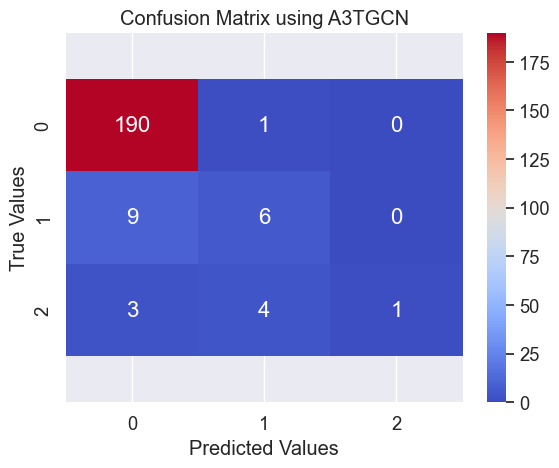

In [51]:
# Plot of the confusion matrix to a heatmap
df_cm = pd.DataFrame(confusion_matrix, range(3), range(3))
ax= plt.subplot()
sns.set(font_scale=1.2)
sns.heatmap(df_cm, cmap="coolwarm", annot=True, annot_kws={"size": 16}, fmt='d', ax = ax)
plt.title('Confusion Matrix')
ax.set_xlabel('Predicted Values')
ax.set_ylabel('True Values')
ax.set_title('Confusion Matrix using A3TGCN')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

In [46]:
for s, mat in enumerate(confusion_matrix):
    print(mat)

[[ 11  12]
 [  1 190]]
[[194   5]
 [  9   6]]
[[206   0]
 [  7   1]]


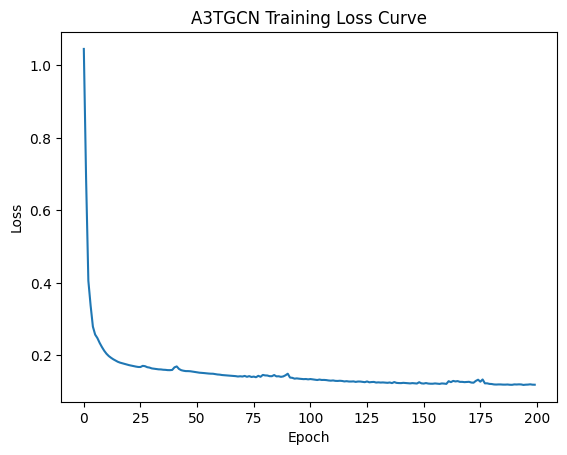

In [27]:
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Α3TGCN Training Loss Curve')
plt.show()